### Import Library

<p>Langkah ini adalah untuk melakukan importing modul yang digunakan pada tahap preprocessing.<p>

In [1]:
import sys
import os

# Naik satu level ke folder utama proyek (Program, sebelumnya folder preprocessing)
sys.path.append(os.path.abspath("..")) # Agar bisa import modul folder lain karena berada di root utama

In [2]:
from features_extraction.gabor import Gabor
from features_extraction.harralick import Harralick
from features_extraction.lbp import LBP
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2

Features_extraction package loaded!


In [3]:
import torch
import logging
from torchvision import transforms
from PIL import Image
import random

### General Preprocessing

In [4]:
BASE_DIR = os.path.abspath("..")  # Naik satu level ke root proyek
# path ke dataset
dataset_path = os.path.join(BASE_DIR, "dataset") # Agar folder dataset dapat dibaca

In [5]:
# Definisikan transformasi augmentasi tahap 1
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

In [52]:
'''
PROSES MENYEIMBANGKAN DATA AGAR MENJADI 200 SETIAP KATEGORI DENGAN AUGMENTASI
'''

# Kelas berdasarkan nama folder
classes = ["Overripe", "Ripe", "Unripe"]

# Jumlah augmentasi yang dibutuhkan per kategori
num_augmentations = {
    "Overripe": 56,
    "Ripe": 17,
    "Unripe": 32,
}

# Definisikan transformasi augmentasi
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(320,340)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Tahap 1: Menyeimbangkan Data
for category in classes:
    folder_path = os.path.join(dataset_path, f'{category}/cropped')
    images = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Acak urutan gambar 
    random.shuffle(images) 

    # Hitung jumlah augmentasi per gambar
    num_aug_per_image = num_augmentations[category] // len(images)  
    remainder = num_augmentations[category] % len(images)  # Sisa bagi

    for i, image_name in enumerate(images):
        image_path = os.path.join(folder_path, image_name)
        img = Image.open(image_path)

        # Terapkan augmentasi sesuai jumlah yang dibutuhkan
        for j in range(1, num_aug_per_image + 1):
            augmented_img = transform(img)
            augmented_img.save(os.path.join(folder_path, f"{image_name[:-4]}_aug_{j}.jpg"))

        # Tambahkan augmentasi untuk sisa bagi
        if i < remainder:  
            augmented_img = transform(img)
            augmented_img.save(os.path.join(folder_path, f"{image_name[:-4]}_aug_{num_aug_per_image + 1}.jpg"))

In [32]:
'''
PROSES MENAMBAHKAN VARIASI DATA DENGAN AUGMENTASI DATASET
'''

# Definisikan transformasi augmentasi tahap 2
transform = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Tahap 2: Augmentasi Menjadi 400 Gambar
for category in classes:
    folder_path = os.path.join(dataset_path, f'{category}/cropped')
    images = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    for image_name in images:
        image_path = os.path.join(folder_path, image_name)
        img = Image.open(image_path)
        
        # Terapkan augmentasi 1 kali
        augmented_img = transform(img)
        augmented_img.save(os.path.join(folder_path, f"{image_name[:-4]}_aug_1.jpg"))  # Simpan dengan nama unik

In [6]:
'''
FUNGSI GENERAL PREPROCESSING UNTUK MELAKUKAN PREPROCESSING SECARA UMUM SEBELUM MASUK KE SPESIFIK PREPROCESSING
'''

def general_preprocessing(image_path):
    # Load image
    image = cv2.imread(image_path)
    
    # Konversi ke grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize image
    resize_image = cv2.resize(gray_image, (128,128), interpolation=cv2.INTER_CUBIC)
    
    return resize_image

In [ ]:
''' 
PROSES UNTUK CROPPING GAMBAR MENGGUNAKAN YOLOv5
'''

# Load model YOLOv5
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# Loop melalui setiap folder (Overripe, Ripe, Unripe)
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    
    # Pastikan folder_path adalah direktori
    if os.path.isdir(folder_path):
        # Buat folder untuk menyimpan hasil cropping jika belum ada
        output_folder = os.path.join(folder_path, "cropped")
        os.makedirs(output_folder, exist_ok=True)

        # Loop melalui setiap gambar dalam folder
        for filename in os.listdir(folder_path):
            if filename.endswith(('.jpg', '.jpeg', '.png')): 
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)

                # Jalankan inference dengan YOLOv5
                results = model(img)

                # Ekstrak bounding box
                detections = results.pandas().xyxy[0]
                for i in range(len(detections)):
                    x_min, y_min, x_max, y_max = map(int, detections.iloc[i][['xmin', 'ymin', 'xmax', 'ymax']])

                    # Crop gambar
                    cropped_img = img[y_min:y_max, x_min:x_max]

                    # Simpan gambar hasil crop
                    output_path = os.path.join(output_folder, f"{filename[:-4]}_cropped_{i}.jpg") 
                    cv2.imwrite(output_path, cropped_img)

In [7]:
# Kelas berdasarkan nama folder
classes = ["Overripe", "Ripe", "Unripe"]

# Menyimpan data gambar dan label
data = []
labels = []

# Iterasi setiap kelas
for label, category in enumerate(classes):
    folder_path = os.path.join(dataset_path, f'{category}/cropped')
    # print(folder_path)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        # print(file_path)
        image = general_preprocessing(file_path)
        
        # Menyimpan data
        data.append(image)
        labels.append(label)

In [8]:
# Cek Jumlah label apakah sudah benar
for index, category in enumerate(classes):
    print(f"Jumlah label {category} adalah {labels.count(index)}")

Jumlah label Overripe adalah 370
Jumlah label Ripe adalah 391
Jumlah label Unripe adalah 384


In [9]:
# Konversi ke array NumPy
data = np.array(data, dtype="float32")
labels = np.array(labels)

print("Jumlah data:", len(data))
print("Jumlah label:", len(labels))

Jumlah data: 1145
Jumlah label: 1145


In [10]:
data = data.astype(np.uint16)

In [11]:
data.shape

(1145, 128, 128)

In [12]:
print(f"Nilai piksel minimum: {np.min(data)}")
print(f"Nilai piksel maksimum: {np.max(data)}")

Nilai piksel minimum: 0
Nilai piksel maksimum: 255


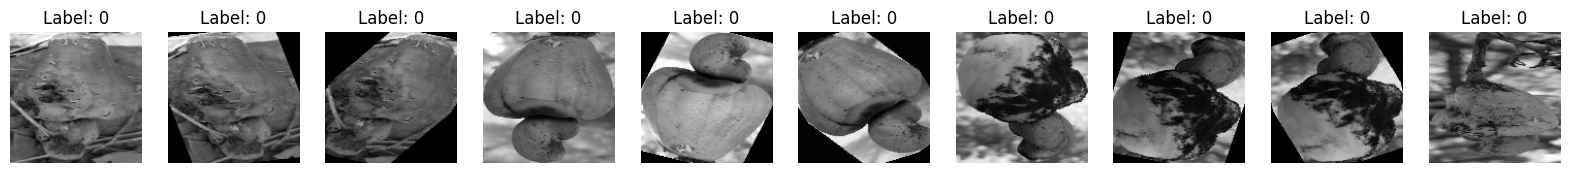

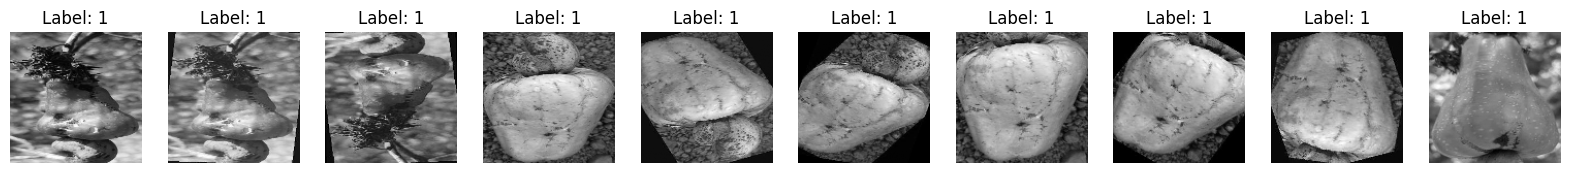

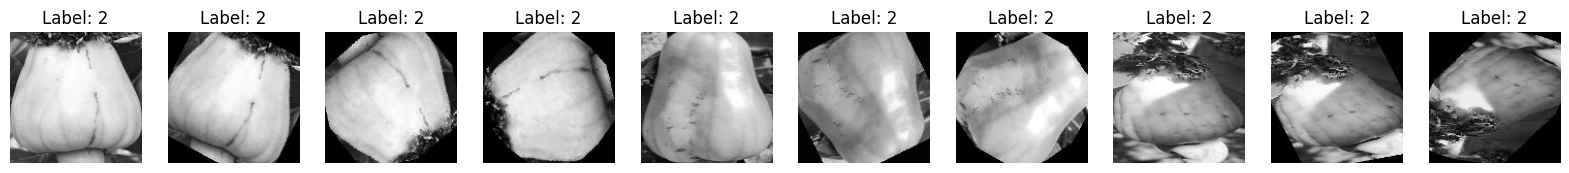

In [13]:
# Menampilkan 10 contoh gambar pertama
num_samples = 10
plt.figure(figsize=(20, 10))

# 10 Label 0 (Overripe)
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data[i], cmap="gray")  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.show()

plt.figure(figsize=(20, 10))
# 10 Label 1 (Ripe)
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data[370+i], cmap="gray")  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[370+i]}")
    plt.axis("off")

plt.show()

plt.figure(figsize=(20, 10))
# 10 Label 2 (Unripe)
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data[781+i], cmap="gray")  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[781+i]}")
    plt.axis("off")

plt.show()

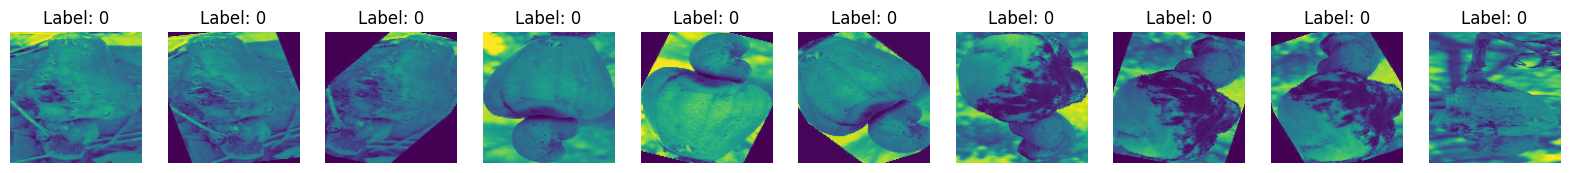

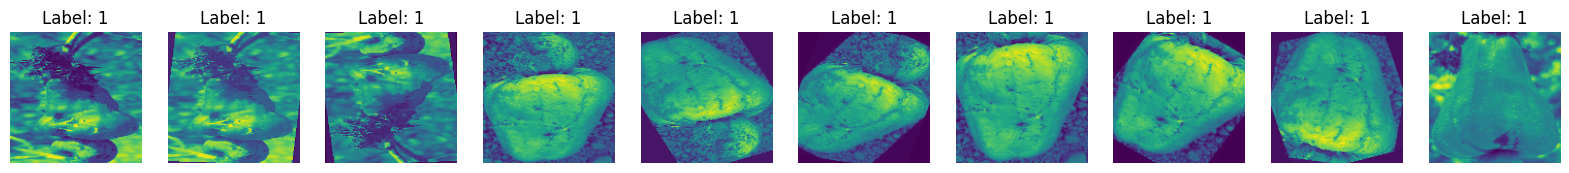

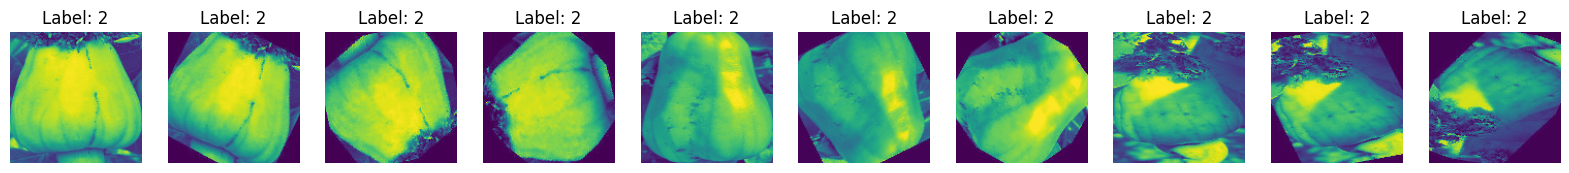

In [71]:
# Menampilkan 10 contoh gambar pertama
num_samples = 10
plt.figure(figsize=(20, 10))

# 10 Label 0 (Overripe)
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data[i])  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.show()

plt.figure(figsize=(20, 10))
# 10 Label 1 (Ripe)
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data[370+i])  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[370+i]}")
    plt.axis("off")

plt.show()

plt.figure(figsize=(20, 10))
# 10 Label 2 (Unripe)
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data[781+i])  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[781+i]}")
    plt.axis("off")

plt.show()

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

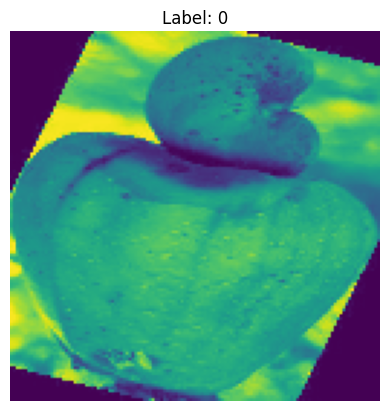

In [68]:
plt.imshow(data[4])  # cmap="gray" agar sesuai dengan grayscale
plt.title(f"Label: {labels[4]}")
plt.axis("off")

In [74]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
tst = pd.DataFrame(data[7]/255)
tst

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011765,0.274510,0.250980,0.247059,0.258824,0.274510,0.258824,0.270588,0.270588,0.274510,0.254902,0.239216,0.223529,0.231373,0.250980,0.321569,0.482353,0.564706,0.627451,0.654902,0.611765,0.568627,0.525490,0.396078,0.321569,0.349020,0.341176,0.356863,0.411765,0.537255,0.654902,0.694118,0.752941,0.760784,0.749020,0.737255,0.713725,0.678431,0.670588,0.694118,0.713725,0.745098,0.776471,0.776471,0.788235,0.796078,0.796078,0.796078,0.803922,0.807843,0.803922,0.803922,0.784314,0.760784,0.760784,0.650980,0.627451,0.674510,0.345098,0.376471,0.000000,0.000000,0.000000,0.019608,0.007843,0.011765,0.000000,0.011765,0.003922,0.003922,0.000000,0.003922,0.023529,0.007843,0.003922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023529,0.309804,0.301961,0.309804,0.305882,0.282353,0.278431,0.309804,0.325490,0.298039,0.290196,0.254902,0.247059,0.231373,0.290196,0.368627,0.431373,0.505882,0.576471,0.643137,0.647059,0.603922,0.541176,0.454902,0.368627,0.317647,0.313725,0.352941,0.400000,0.490196,0.580392,0.623529,0.709804,0.725490,0.729412,0.733333,0.705882,0.698039,0.662745,0.654902,0.698039,0.694118,0.713725,0.741176,0.772549,0.788235,0.803922,0.819608,0.819608,0.815686,0.796078,0.772549,0.725490,0.682353,0.627451,0.674510,0.596078,0.517647,0.462745,0.423529,0.458824,0.419608,0.356863,0.419608,0.286275,0.023529,0.054902,0.011765,0.003922,0.003922,0.003922,0.000000,0.047059,0.000000,0.003922,0.003922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003922,0.003922,0.003922,0.003922,0.003922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074510,0.309804,0.368627,0.341176,0.329412,0.337255,0.325490,0.352941,0.364706,0.321569,0.317647,0.258824,0.305882,0.290196,0.278431,0.356863,0.427451,0.537255,0.584314,0.635294,0.627451,0.600000,0.556863,0.458824,0.388235,0.333333,0.309804,0.321569,0.360784,0.423529,0.498039,0.552941,0.658824,0.682353,0.694118,0.701961,0.678431,0.682353,0.682353,0.694118,0.701961,0.745098,0.701961,0.698039,0.705882,0.733333,0.760784,0.784314,0.800000,0.811765,0.807843,0.784314,0.741176,0.701961,0.615686,0.509804,0.443137,0.384314,0.388235,0.372549,0.364706,0.345098,0.329412,0.309804,0.364706,0.337255,0.352941,0.380392,0.423529,0.200000,0.149020,0.058824,0.000000,0.000000,0.007843,0.011765,0.000000,0.000000,0.003922,0.003922,0.003922,0.003922,0.000000,0.000000,0.000000,0.003922,0.003922,0.003922,0.003922,0.007843,0.003922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

### Spesific Preprocessing

### Harralick Features Extraction

In [14]:
print(f"Nilai piksel minimum: {np.min(data)}")
print(f"Nilai piksel maksimum: {np.max(data)}")

Nilai piksel minimum: 0
Nilai piksel maksimum: 255


In [96]:
# Kombinasi d dan theta
kombinasiFeature = [[1, 2, 3], [0, 45, 90, 135]]
# kombinasiFeature = [[1], [0]]

# # index untuk data
# img = 0

for d in kombinasiFeature[0]:
    for theta in kombinasiFeature[1]:
        data_fitur = []  # List untuk menyimpan fitur semua gambar untuk kombinasi ini
        img = 0 # Index untuk data
        for index in range(len(data)):
            try:
                # print(f"gambar ke:, {img+1} sukses!!!")
                # Inisialisasi objek GLCM dengan kombinasi d dan theta
                glcm_calculator = Harralick(d=d, theta=theta)

                # Hitung Matriks GLCM
                glcm_matrix = glcm_calculator.calculate_glcm(data[index])

                # Hitung semua fitur Harralick dari matriks GLCM
                features = glcm_calculator.get_all_features(glcm_matrix)

                # Tambahkan ID gambar dan label ke dictionary fitur
                features['image'] = f'img-{img}'
                features['label'] = labels[index]

                data_fitur.append(features)

                img += 1
            except Exception as e:
                print(e)
            

        # Simpan DataFrame hanya jika ada data
        if data_fitur:
            df = pd.DataFrame(data_fitur)
            filename = f'features_d{d}_theta{theta}.csv'
            df.to_csv(filename, index=False)
            print(f"File {filename} berhasil disimpan!")
        else:
            print(f"Tidak ada data untuk d={d}, theta={theta}. File tidak disimpan.")

File features_d1_theta0.csv berhasil disimpan!
File features_d1_theta45.csv berhasil disimpan!
File features_d1_theta90.csv berhasil disimpan!
File features_d1_theta135.csv berhasil disimpan!
File features_d2_theta0.csv berhasil disimpan!
File features_d2_theta45.csv berhasil disimpan!
File features_d2_theta90.csv berhasil disimpan!
File features_d2_theta135.csv berhasil disimpan!
File features_d3_theta0.csv berhasil disimpan!
File features_d3_theta45.csv berhasil disimpan!
File features_d3_theta90.csv berhasil disimpan!
File features_d3_theta135.csv berhasil disimpan!


In [97]:
# Membaca semua file csv harralick fiturs
list_harralick_dfs = []

''' 
index 0 = harralick_df_d1_theta0 = pd.read_csv('features_d1_theta0.csv')
index 1 = harralick_df_d1_theta45 = pd.read_csv('features_d1_theta45.csv')
index 2 = harralick_df_d1_theta90 = pd.read_csv('features_d1_theta90.csv')
index 3 = harralick_df_d1_theta135 = pd.read_csv('features_d1_theta135.csv')
index 4 = harralick_df_d2_theta0 = pd.read_csv('features_d2_theta0.csv')
index 5 = harralick_df_d2_theta45 = pd.read_csv('features_d2_theta45.csv')
index 6 = harralick_df_d2_theta90 = pd.read_csv('features_d2_theta90.csv')
index 7 = harralick_df_d2_theta135 = pd.read_csv('features_d2_theta135.csv')
index 8 = harralick_df_d3_theta0 = pd.read_csv('features_d3_theta0.csv')
index 9 = harralick_df_d3_theta45 = pd.read_csv('features_d3_theta45.csv')
index 10 = harralick_df_d3_theta90 = pd.read_csv('features_d3_theta90.csv')
index 11 = harralick_df_d3_theta135 = pd.read_csv('features_d3_theta135.csv')
'''

for d in kombinasiFeature[0]:
    for theta in kombinasiFeature[1]:
        df = pd.read_csv(f"features_d{d}_theta{theta}.csv")
        df = df.set_index('image')
        list_harralick_dfs.append(df)

In [123]:
list_harralick_dfs[11]

,energy,contrast,correlation,variance,homogeneity,sum_average,sum_variance,sum_entropy,entropy,difference_variance,difference_entropy,information_measure_of_correlation1,information_measure_of_correlation2,max_correlation_coefficient,label
image,,,,,,,,,,,,,,,
img-0,0.000225,824.089695,0.753313,1737.368310,0.150825,228.406022,19158.279276,12.569343,12.569343,9436.338154,12.569343,8.753575,8.753575,0.001071,0
img-1,0.002497,993.941295,0.748144,1986.218986,0.195306,173.475057,14472.181602,12.074325,12.074325,5252.563407,12.074325,8.390870,8.390870,0.046863,0
img-2,0.027293,529.032313,0.835520,1641.149066,0.318799,117.985198,9431.741134,10.592623,10.592623,2464.064890,10.592623,7.791699,7.791699,0.163895,0
img-3,0.000352,506.217876,0.853834,1732.338132,0.192374,242.374339,20988.047219,12.210854,12.210854,12072.214815,12.210854,8.425849,8.425849,0.006362,0
img-4,0.007046,1207.639960,0.850424,4030.412332,0.243388,257.951121,31615.916733,11.788183,11.788183,13317.634305,11.788183,7.669902,7.669902,0.082326,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
img-1140,0.000168,941.302532,0.860064,3381.483931,0.160905,295.119237,34363.715815,12.856684,12.856684,17227.248808,12.856684,8.848689,8.848689,0.000756,2
img-1141,0.001388,1054.694822,0.855956,3665.397931,0.223141,250.606891,29283.955674,12.191114,12.191114,12484.509560,12.191114,9.594889,9.594889,0.032754,2
img-1142,0.000250,888.877110,0.796402,2170.986601,0.171282,206.167989,18368.070433,12.558232,12.558232,7905.066377,12.558232,7.666547,7.666547,0.001386,2


### Gabor Features Extraction

In [15]:
gabor_features = []

for img in range(len(data)):
    gabor_filter = Gabor(sigma=1, theta=0, frequency=0.1, Lambda=10, gamma=0.5)
    filtered_img = gabor_filter.apply_filter(data[img])
    features = gabor_filter.get_features(filtered_img)
    gabor_features.append(features)

gabor_df = pd.DataFrame(gabor_features)

# Mengganti nama kolom sesuai dengan fiturnya
new_columns = {0:'mean', 1:'std', 2:'skewness', 3:'kurtosis',4:'energi',5:'fase'}
gabor_df = gabor_df.rename(columns=new_columns)
gabor_df['label'] = labels

In [20]:
filename = f'gabor_features.csv'
gabor_df.to_csv(filename, index=False)

In [18]:
gabor_df

,mean,std,skewness,kurtosis,energi,fase,label
0,1072.417969,344.470154,0.910663,1.675313,2.078704e+10,0.000000,0
1,808.786194,384.256744,0.069924,1.390039,1.313650e+10,0.014573,0
2,549.542969,354.278656,-0.150746,-0.458540,7.004338e+09,0.017449,0
3,1141.138428,371.449097,0.599915,1.688863,2.359577e+10,0.000000,0
4,1203.018555,574.177856,-0.822286,-0.074542,2.911328e+10,0.019750,0
...,...,...,...,...,...,...,...
1140,1384.744385,524.002258,-0.196588,-1.209712,3.591529e+10,0.000000,2
1141,1167.399536,558.952820,-0.390426,-0.913804,2.744729e+10,0.012272,2
1142,971.648071,399.822510,0.317966,0.444536,1.808725e+10,0.000000,2
1143,807.583435,521.631042,0.259587,-0.174910,1.514357e+10,0.017066,2


### LBP Features Extraction